# Generating Shakespeare Sonnets with Deep Learning
---
Creating a character-level language model trained on William Shakespeare's sonnets.

## Data Loading & Visualization

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(21)

print("Numpy version:", np.__version__)

Numpy version: 1.12.1


Our corpus is composed of all of William Shakespeare's sonnets concatenated into a single text file. The sonnets were retrieved from [shakespeares-sonnets.com](http://www.shakespeares-sonnets.com/all.php). There are a total of 154 sonnets in the corpus.

In [2]:
with open('sonnets.txt', 'r') as f:
    data = f.read().lower()

print("Corpus length: %d characters" % len(data))

Corpus length: 94082 characters


Average sonnet length: 608.94 characters


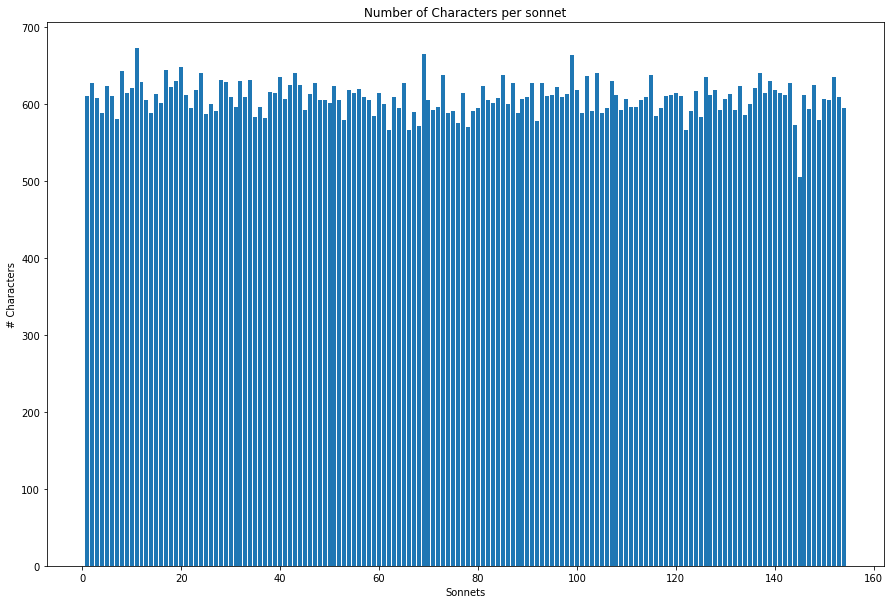

In [3]:
# Visualize sonnet character length
sonnets = data.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

plt.figure(figsize=(15,10))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens)
plt.title('Number of Characters per sonnet')
plt.ylabel('# Characters')
plt.xlabel('Sonnets')
plt.show()

Sonnet 145 is Shakespeare's shortest sonnet at 506 characters long while sonnet 11 is the longest with 673 characters. Since the average sonnet length is ~608 characters long when we generate characters later we will generate 600 characters to create 1 sonnet.

## Vectorization
---
Now we will set the maximum length a sequence can have, how many characters to skip when we grab a new sample, and create a vector of targets (the next character in the sequence). The `sentences` variable will hold all our training samples where each sample will be 40 characters from the dataset offset by 3 characters from the previous sample. Here is an example where `maxlen` is 40 and `step` is 3:

**Sentence 1:**
    
    'from fairest creatures we desire increas'

**Target 1:**

    'e'

**Sentence 2:**

    'm fairest creatures we desire increase,\n'

**Target 2:**

    't'
    
**Sentence 3:**

    'airest creatures we desire increase,\ntha'

**Target 3:**

    't'
    
For context here are the first 100 characters in the corpus:
    
    'from fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the ri'

In [4]:
# Max length of each sequence
maxlen = 40

# Sample new sequence every step characters
step = 3

sentences = []
targets = []

# Loop through sonnets and create sequences and associated targets
for i in range(0, len(data) - maxlen, step):
    sentences.append(data[i:i + maxlen])
    targets.append(data[maxlen + i])

print("Number of sequences:", len(sentences))

# Grab all unique characters in corpus
chars = sorted(list(set(data)))
print("Number of unique characters:", len(chars))

# Dictionary mapping unique character to integer indices
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 31348
Number of unique characters: 38


Now we will vectorize our data into a one-hot encoded tensor of shape **(num_sequences, max_sequence_length, num_characters)**.

In [5]:
# Vectorize sequences and targets
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        x[i, j, char_indices[char]] = 1
    y[i, char_indices[targets[i]]] = 1

print("Size of training sequences:", x.shape)
print("Size of training targets:", y.shape)

Size of training sequences: (31348, 40, 38)
Size of training targets: (31348, 38)


## Build Model
---
Here we will build and compile the deep learning model using Keras. The model will consist of 1 LSTM layer with a fully connected layer on top. The output has a softmax activation function applied so the output can be represented as a probability for each character in our list of possible characters.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               85504     
_________________________________________________________________
dense_1 (Dense)              (None, 38)                4902      
Total params: 90,406
Trainable params: 90,406
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.optimizers import SGD

optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

The model will output a probability value for each character possible. Instead of choosing the character with the highest probability, we will reweight the probabilities and sample from them based on a "temperature" value. The higher the temperature the more likely a random character will be chosen, the lower the temperature the more deterministic the model will behave.

In [8]:
def sample(preds, temperature=1.0):
    ''' Reweight the predicted probabilities and draw sample from newly created probability distribution. '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Now the model will be trained on the text and targets. After training for 1 epoch, a random sequence will be chosen from the training corpus and fed into the model. Using this "seed text" we will predict the next 600 characters at different temperatures and store them in different text files locally.

In [9]:
epochs = 60

loss = []  # Custom history list to save model's loss

# Create directory to store generated text
base_dir = 'generated_text'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    # Fit model for 1 epoch then generate text given a seed.
    history = model.fit(x, y, batch_size=128, epochs=1)
    loss.append(history.history['loss'][0])
    
    # Create directory to store text for each epoch
    epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
    if not os.path.isdir(epoch_dir):
        os.mkdir(epoch_dir)
    
    # Select a random seed text to feed into model and generate text
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    seed_text = data[start_idx:start_idx + maxlen]
    for temp in [0.2, 0.5, 1.0, 1.3]:
        generated_text = seed_text
        temp_file = 'epoch' + str(epoch) + '_temp' + str(temp) + '.txt'
        file = open(os.path.join(epoch_dir, temp_file), 'w')
        file.write(generated_text)
        
        # Predict and generate 600 characters (approx. 1 sonnet length)
        for i in range(600):
            # Vectorize generated text
            sampled = np.zeros((1, maxlen, len(chars)))
            for j, char in enumerate(generated_text):
                sampled[0, j, char_indices[char]] = 1.
            
            # Predict next character
            preds = model.predict(sampled, verbose=0)[0]
            pred_idx = sample(preds, temperature=temp)
            next_char = chars[pred_idx]
            
            # Append predicted character to seed text
            generated_text += next_char
            generated_text = generated_text[1:]
            
            # Write to text file
            file.write(next_char)
        print('Temp ' + str(temp) + " done.")
        file.close()

Epoch 1
Epoch 1/1
31348/31348 [==============================] - 30s 947us/step - loss: 3.1130
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 2
Epoch 1/1
31348/31348 [==============================] - 30s 948us/step - loss: 2.9861
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 3
Epoch 1/1
31348/31348 [==============================] - 30s 972us/step - loss: 2.9697
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 4
Epoch 1/1
31348/31348 [==============================] - 30s 960us/step - loss: 2.9458
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 5
Epoch 1/1
31348/31348 [==============================] - 31s 982us/step - loss: 2.9076
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 6
Epoch 1/1
31348/31348 [==============================] - 30s 956us/step - loss: 2.8379
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 7
Epoch 1/1
31348/31348 [==============================] - 30s 9

Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 54
Epoch 1/1
31348/31348 [==============================] - 30s 963us/step - loss: 1.8354
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 55
Epoch 1/1
31348/31348 [==============================] - 30s 947us/step - loss: 1.8295
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 56
Epoch 1/1
31348/31348 [==============================] - 30s 952us/step - loss: 1.8241
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 57
Epoch 1/1
31348/31348 [==============================] - 30s 947us/step - loss: 1.8179
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 58
Epoch 1/1
31348/31348 [==============================] - 30s 965us/step - loss: 1.8112
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 59
Epoch 1/1
31348/31348 [==============================] - 30s 964us/step - loss: 1.8040
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoc

## Generating New Sonnets
---
Here we will pick a random seed text from the training data and predict 600 (average sonnet length) new characters using our newly trained model. We will also use a temperature of 0.5 because that gives a good balance between randomness and deterministic behaviour.

In [14]:
def generate_sonnet(temp):
    ''' Given a temperature, generate a new sonnet '''
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    new_sonnet = data[start_idx:start_idx + maxlen]
    sys.stdout.write(new_sonnet)
    for i in range(600):
        # Vectorize generated text
        sampled = np.zeros((1, maxlen, len(chars)))
        for j, char in enumerate(new_sonnet):
            sampled[0, j, char_indices[char]] = 1.

        # Predict next character
        preds = model.predict(sampled, verbose=0)[0]
        pred_idx = sample(preds, temperature=temp)
        next_char = chars[pred_idx]

        # Append predicted character to seed text
        new_sonnet += next_char
        new_sonnet = new_sonnet[1:]

        # Print to console
        sys.stdout.write(next_char)
        sys.stdout.flush()

In [10]:
# Generate new sonnets at 0.5 temperature
generate_sonnet(0.5)

 art blamed shall not be thy defect,
for the creves and my mast ponge me for dome.
the shald so sweet from be the suring thee,
when thou thee art thou do the should dose men wher stinger, and stire the conter the creat,
the sal to bing ald the with sheed all and,
and hace the mine love the sor dear thing,
to may thas the ort in thee that heart cheant;
the ssorl so seare the of the woul thou shate all thee worth thee fart o thee,
for my nes the stire the hear whing i tree.

his it she proon where my semer the still greet,
and the mes preas the sum the burt of thee,
what the se for more the eve the soul so thee.

wher hat the stare ma

In [11]:
# Generate new sonnets at 0.2 temperature
generate_sonnet(0.2)

 sake lay on me this cross:
but here's the stree the sweet with the seart,
and the stare the see my see wher the store,
the should the stire the stree the sur thee,
and the still the san the stare the see be the store,
and i st me for me of the stee the sered
my the ere the sor the spee when the seet,
the so the sor more the sere the sweet steee.
the prough the sure the sell in the sell
when the the ere wher hand the sweet shath the see the sered
and the store the sweet wher hath the sered the see the seed
and the stire the seres wher shat thou shat the sere the see the seet steee,
the sor the ser the spore the sure the see,
the sor

Based on the model's output above it learns to format the sonnet correctly most of the time and seems to have learned to separate words with spaces which is impressive since this is a character-level language model. Something interesting it does is it adds punctuation to the end of most lines which is exactly what Shakespeare does in his sonnets. The output where the temperature is 0.2 has a lot of repetition in it. It is probably entering a loop where it sees some sequence of characters before it and predicts the same characters over and over again. This is evident in the last few lines where words like "see the seed" and "the sor" and "and the" appear frequently. Although this behaviour can be expected with such a low temperature. There is not much change to the probability distribution after reweighting the model's outputs.

The first example at temperature 0.5 has more word variety but also more spelling mistakes due to the fact that there is more randomness involved in choosing the next character.

Below the temperature is higher meaning that there will be more random guessing for the next character which explains why there are a lot of spelling mistakes and bizarre words. I think 0.5 is a good temperature for resampling probabilities because too high (1.0 and up) will cause the model to output lot of random letters and will end up being a jumbled mess.

In [12]:
# Generate new sonnet with 1.0 temp
generate_sonnet(1.0)

then, dear friend, and i assure ye,
even, he strmins bmire heal ber)eng thou, shagl thou, fedl thou, to may ther's demine,
he race an buwt ghin to thou thow weath repr;sing my fun,
not ha loo hou and owe lovers for eyer dome
the sporce ay more in then to not were piepsent withs owh bres,
whenche for he sable whar beauty; swmer' ariss sthem stall, mar by yfoul,
whore ched othestrus be that whight dooun,
with re bace mone all swill kide sugh and adaradt
hat mis po you leve the noul ancus me mean
beeet fear shelus were)y my nevire the wronkt';;
chence aixe of when gaaguugh and mumi's;
with that you theer is ad of rence pulld,
thy lood,

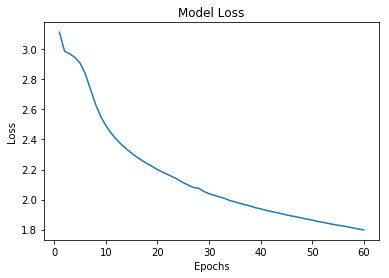

In [16]:
# Plot model loss over epochs
plt.plot([i for i in range(1, epochs+1)], loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

Now we will save the final model for future use.

In [17]:
# Save model
model.save('shakespeare_sonnet_model.h5')

## Things To Try
---
1. Stack recurrent layers
2. Add bidirectional lstm layers
3. Change maximum length of sequences (`maxlen` variable)
4. Change step size (`step` variable)
5. Train over longer epochs
6. Change number of lstm units
7. Experiment with different optimizers (rmsprop, adam)
8. Try word-level language model

In [ ]:
from keras.models import load_model

# Load model
model = load_model('shakespeare_sonnet_model.h5')